# Finetune EfficientNet-B5


## efficientnetb5_1080repetitive


With 1920x1080 repetitive-padded melspectrogram images with data augmentation on the train set (Gaussian noise addition, time stretching and pitch scaling)


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import random

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
model_name = 'efficientnetb5_1080repetitive_3_augmented'

train_csv = '../../../data/augmentation/melspectrogram_train_dataset_augmented.csv'
test_csv = '../../../data/augmentation/melspectrogram_test_dataset.csv'
val_csv = '../../../data/augmentation/melspectrogram_val_dataset.csv'
root_dir = '../../../data/augmentation/'
class_weights_path = '../../../data/class_weights.pt'

Import other helper classes


In [6]:
from cnn.datasets.MelspectrogramDataset import MelSpectrogramDataset
from cnn.pipeline.Pipeline import Pipeline

Define the model


In [7]:
model = models.efficientnet_b5(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [8]:
# Number of classes
num_classes = 9

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Modify final fully connected layer according to number of classes
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# Unfreeze the last 5 layers so that they can be fine-tuned
# Adjust the indices based on the actual number of layers in model.features
for idx in [-5, -4, -3, -2, -1]:  # Use negative indices to target the last 5 layers
    for param in model.features[idx].parameters():
        param.requires_grad = True

# Replace classifier
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# Unfreeze classifier
for param in model.classifier.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [9]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    # Resize the Mel spectrogram to 456x456, suitable for EfficientNet-B5
    transforms.Resize((456, 456)),
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

num_epochs = 50

C:\Users\profi\AppData\Local\Temp\ipykernel_26784\2770681902.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)


Prepare datasets and dataloaders


In [10]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=24,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=24,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=24,
                        shuffle=False, num_workers=8, pin_memory=True)

Execute the pipeline


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/50


Validating: 100%|██████████| 395/395 [00:58<00:00,  6.76it/s, Loss=0.5591512322425842, Elapsed=70.1805s, ETA=0.0000s]  


Epoch 1 completed in 2379.8239s
Train Loss: 0.8124032985859236 - Train Accuracy: 66.71603989054974
Validation Loss: 0.6396026377813726 - Validation Accuracy: 75.2849303503588

Epoch 2/50


Validating: 100%|██████████| 395/395 [00:58<00:00,  6.77it/s, Loss=0.41148701310157776, Elapsed=70.1618s, ETA=0.0000s] 


Epoch 2 completed in 2380.9581s
Train Loss: 0.5536978311554708 - Train Accuracy: 77.29585491056285
Validation Loss: 0.6190152024166493 - Validation Accuracy: 77.54326720135079

Epoch 3/50


Validating: 100%|██████████| 395/395 [00:58<00:00,  6.80it/s, Loss=0.2394123375415802, Elapsed=71.7344s, ETA=0.0000s]  


Epoch 3 completed in 2383.6282s
Train Loss: 0.42160316339674125 - Train Accuracy: 82.3302277198616
Validation Loss: 0.5803005869347083 - Validation Accuracy: 82.13381173490924

Epoch 4/50


Validating: 100%|██████████| 395/395 [00:58<00:00,  6.78it/s, Loss=0.22822877764701843, Elapsed=70.0910s, ETA=0.0000s]  


Epoch 4 completed in 2381.9474s
Train Loss: 0.3139640708897314 - Train Accuracy: 86.2831007892178
Validation Loss: 0.6539179244279107 - Validation Accuracy: 80.94132545377796

EarlyStopping counter: 1/5
Epoch 5/50


Validating: 100%|██████████| 395/395 [00:58<00:00,  6.80it/s, Loss=0.08783455193042755, Elapsed=69.8941s, ETA=0.0000s]  


Epoch 5 completed in 2380.6882s
Train Loss: 0.23817018264018402 - Train Accuracy: 89.13638316636892
Validation Loss: 0.7802172769332612 - Validation Accuracy: 82.22878851836218

EarlyStopping counter: 2/5
Epoch 6/50


Validating: 100%|██████████| 395/395 [00:57<00:00,  6.81it/s, Loss=0.31317394971847534, Elapsed=69.7950s, ETA=0.0000s]  


Epoch 6 completed in 2380.4747s
Train Loss: 0.18933683793851303 - Train Accuracy: 91.26433142624545
Validation Loss: 0.8023376040679367 - Validation Accuracy: 82.46095398902492

EarlyStopping counter: 3/5
Epoch 7/50


Validating: 100%|██████████| 395/395 [00:58<00:00,  6.81it/s, Loss=0.40066659450531006, Elapsed=69.6338s, ETA=0.0000s] 


Epoch 7 completed in 2380.1495s
Train Loss: 0.15422788623613262 - Train Accuracy: 92.84220166889034
Validation Loss: 1.0081856067587114 - Validation Accuracy: 83.0941325453778

EarlyStopping counter: 4/5
Epoch 8/50


Validating: 100%|██████████| 395/395 [00:58<00:00,  6.80it/s, Loss=0.17334239184856415, Elapsed=69.6628s, ETA=0.0000s]  

Epoch 8 completed in 2380.2464s
Train Loss: 0.13059233097517664 - Train Accuracy: 94.00398000949775
Validation Loss: 1.0279028406767527 - Validation Accuracy: 82.47150696496412

EarlyStopping counter: 5/5
🔁 Early stopping triggered!


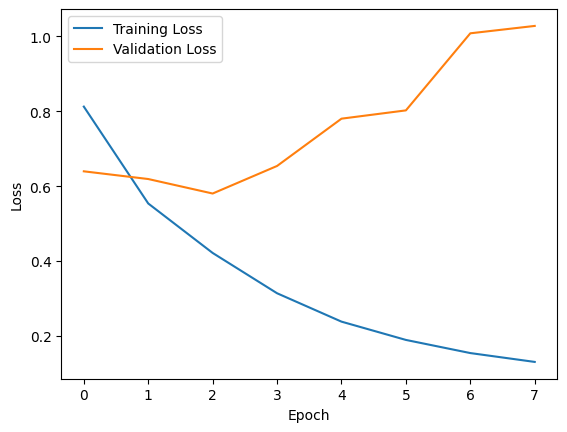

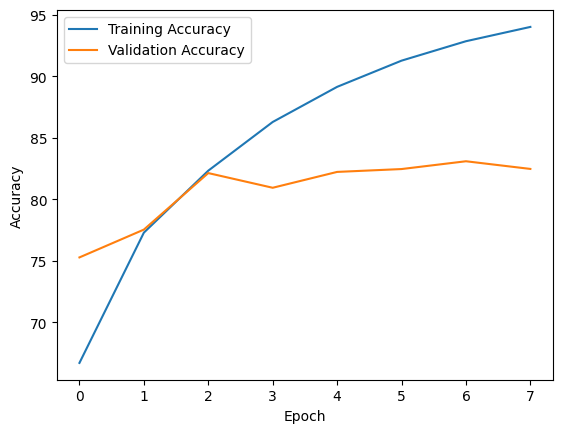

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\cnn\pipeline\Pipeline.py:217: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torc

Evaluating best model on test set...


Testing: 100%|██████████| 395/395 [01:09<00:00,  5.65it/s]

Test Accuracy: 0.8277
Test Precision: 0.8280
Test Recall: 0.8277
Test F1-score: 0.8260

              precision    recall  f1-score   support

       Anger       0.81      0.80      0.80       916
       Bored       0.91      0.92      0.92      1098
     Disgust       0.78      0.48      0.60       291
        Fear       0.64      0.57      0.61       308
       Happy       0.85      0.80      0.82      1914
     Neutral       0.80      0.82      0.81      2226
    Question       0.93      0.96      0.95      1139
         Sad       0.74      0.87      0.80       857
    Surprise       0.78      0.81      0.80       728

    accuracy                           0.83      9477
   macro avg       0.81      0.78      0.79      9477
weighted avg       0.83      0.83      0.83      9477



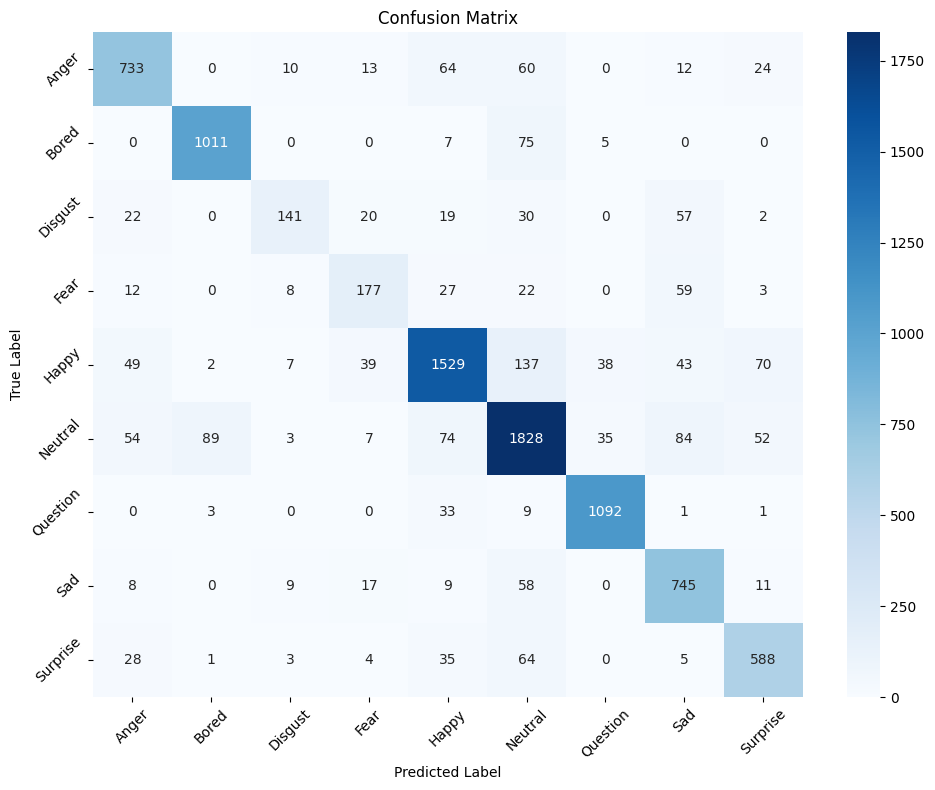

In [11]:
Pipeline.execute(
    model=model,
    labelmap=trainset.label_map,
    trainloader=trainloader,
    valloader=valloader,
    testloader=testloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    model_name=model_name,
    patience=5
)